# Yoga Studio Registration Analysis


In the world of Yoga Studios, knowing your local audience is crucial for success. Summit Sol recently went under a change of ownership as well as a rebrand but holds the same values to its heart. Maintaining its current members as well as converting new ones is the owner's goal to continue to build community in this yoga space. 

In this analysis, data from Summit Sol yoga class registrations is observed to gain a deeper understanding of the current attendance trends and assist scheduling in the future. Registration Data comes from the last year of attendance. It can be accessed and viewed using: **"03-23 to 03-24 registration data.csv"**

Summit Sol is a midsized mountain-town studio with ~100 recurring monthly members and a client base of 500. *Summit County, Colorado* is an area with 3 nearby towns at its center: Dillon, Frisco, and Silverthorne. This area is one to visit if you can! The studio itself is nestled in Dillon within 20 miles of Colorado's 7 biggest ski resorts, surrounded by nature and alpine activities in the summer. 

The known seasonal trend is that the transitional months like April, May, October, and November have lower attendance and peak months have higher (as to be expected in a town that draws millions of tourists each year).Even in these fluctuations trends in class times can be observed and isolated by season to make educated decisions moving forward. 

**The goal of this analysis is to observe the trends from the past year's data to find which class times and styles are the most attended and which classes are the least attended. 

 

**Author's note:**
This analysis my first more full length coding projects. This report is code forward with analysis in the end, referencing tables and functions from above. Many of these functions were written to be used again at a later date with the Studio owner and to have modifiable date inputs. If there are better ways that things could be organized or formatted for efficiency and understandability, please don't hesitate to file a bug and let me know. 

In [1]:
# Here we go
# Import the necessary libraries 
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# A function to read, copy, add minor formatting to make the data set easier to work with
# Original is under original_df, the working data set is stored under DF 

def readfile(file_name):
    # change file name for new report
    df = pd.read_csv(file_name)
    df2 = df.copy()
    
    # The gender columns are not very relevant to us as the teachers rarely fill it out

    df2 = df2.drop(['Males', 'Females', 'Non-Binary', 'Unknown Gender',
       'Anonymous Males', 'Anonymous Females', 'Anonymous Unknown Gender'], axis = 1)
    
    # Apply string replacements to 'Class Name' column to fix "&" and "'"
    df2['Class Name'] = df2['Class Name'].str.replace('&amp;', 'and').str.replace("&#039;", "'")
    
    #Remove the classes with 'Pinna's final classes' as they were special classes for a goodbye
    df2 = df2[~df2['Class Name'].str.contains('Pinna')]
    
    # We'll make another data set for later to separate the $8 promo classes in slow season
    eight_dollar_classes = df2[df2['Class Name'].str.contains('\$8')]
    eight_dollar_promo = eight_dollar_classes.groupby(['Class Name', 'Start Time for Class'])
    
    # Remove $8 classes from df2 as well 
    df2 = df2[~df2['Class Name'].str.contains('\$8')]
    
    return df, df2 , eight_dollar_promo

file_name = '03-23 to 03-24 registration data.csv'

original_df , DF , eight_dollar_promo = readfile(file_name)

# A little peek
DF.tail()

<>:21: SyntaxWarning: invalid escape sequence '\$'
<>:25: SyntaxWarning: invalid escape sequence '\$'
<>:21: SyntaxWarning: invalid escape sequence '\$'
<>:25: SyntaxWarning: invalid escape sequence '\$'
/var/folders/61/0_l78kds2tn8v5_4v5frblqc0000gn/T/ipykernel_3822/2825170881.py:21: SyntaxWarning: invalid escape sequence '\$'
  eight_dollar_classes = df2[df2['Class Name'].str.contains('\$8')]
/var/folders/61/0_l78kds2tn8v5_4v5frblqc0000gn/T/ipykernel_3822/2825170881.py:25: SyntaxWarning: invalid escape sequence '\$'
  df2 = df2[~df2['Class Name'].str.contains('\$8')]


,Class Name,Date of Class,Start Time for Class,Total Attendance
1307,Align and Flow,3/30/2024,09:00:00 AM,14
1308,Align and Flow,3/30/2024,10:30:00 AM,10
1309,Align and Flow,3/31/2024,09:00:00 AM,5
1310,Yin Flow,3/31/2024,10:30:00 AM,7
1311,Slow Flow (75 mins),3/31/2024,05:00:00 PM,6


**Now that we have the table organized into a useful format, lets crunch some general numbers**

The next function allows the user to input a date range in M/D/YYYY format and it will find the average attendance for all of the classes within that range. 

It removes one outlier from the top, and corrects some characters in the date frame

## Average Attendance for Each Unique Class (based off class name and start time)

In [3]:
# This function finds the average attendance for each unique class based off of class name and start time

def find_average_attendance(DF, start_date=None, end_date= None):
    
    # Convert date strings to datetime objects
    DF['Date of Class'] = pd.to_datetime(DF['Date of Class'], format='%m/%d/%Y')
    
    # Filter DataFrame based on date range if provided
    if start_date is not None and end_date is not None:
        start_date = datetime.strptime(start_date, '%m/%d/%Y')
        end_date = datetime.strptime(end_date, '%m/%d/%Y')
        DF = DF[(DF['Date of Class'] >= start_date) & (DF['Date of Class'] <= end_date)]
        date_string = f'{start_date.strftime("%m/%d/%Y")} thru {end_date.strftime("%m/%d/%Y")}'
    else:
        date_string = '3/1/2023 - 3/31/2024'
    
    # Calculate average attendance for each class and rename Total Attendance to Average Attendance
    average_attendance_df = DF.groupby(['Class Name', 'Start Time for Class'])['Total Attendance'].mean().reset_index().round(2)
    average_attendance_df = average_attendance_df.rename(columns={'Total Attendance': 'Average Attendance'})
    
    # Remove the sun emoji from the 'Class Name' column
    average_attendance_df['Class Name'] = average_attendance_df['Class Name'].str.replace('☀️', '')
    
    # Remove Yin w SoundBath Shavasana because it is a special event and is always full 
    average_attendance_df = average_attendance_df[average_attendance_df['Class Name'] != 'Yin w/Sound Bath Shavasana']
    
    # Sort by average attendance
    sorted_average_attendance = average_attendance_df.sort_values(by='Average Attendance', ascending=False).reset_index(drop=True)
    sorted_average_attendance.index.name = 'Rank'
    
    return sorted_average_attendance, date_string

# It is adjustable for dates and will affect the graph below
# If you'd like to average the whole set, leave the dates as None - this data set ranges from 3/1/2023 to 3/31/2024
# incorrect dates will not cause an error, but will only average from the data available

average_attendance, date_string = find_average_attendance(DF, start_date = None, end_date = None)

average_attendance

,Class Name,Start Time for Class,Average Attendance
Rank,,,
0,Loving Kindness Yoga,09:00:00 AM,20.00
1,Align + Flow,09:00:00 AM,19.33
2,(Outdoor) Yoga @ LAWN at Lake Dillon,10:30:00 AM,18.00
3,Candlelight Yin,05:00:00 PM,18.00
4,Align + Flow,10:30:00 AM,16.67
5,(Outdoor) Yoga @ LAWN at Lake Dillon,09:00:00 AM,16.15
6,Align + Flow Level II,07:30:00 AM,14.33
7,Sunrise Power Yoga,07:00:00 AM,14.00
8,Sunrise Yoga,07:00:00 AM,13.83


Wow thats a lot of different classes! We've got plenty to dig into here already. The next function plots this information to show it visually.

## Figure 1: Average Attendance for Each Class at a Particular Start Time 3/23-3/24

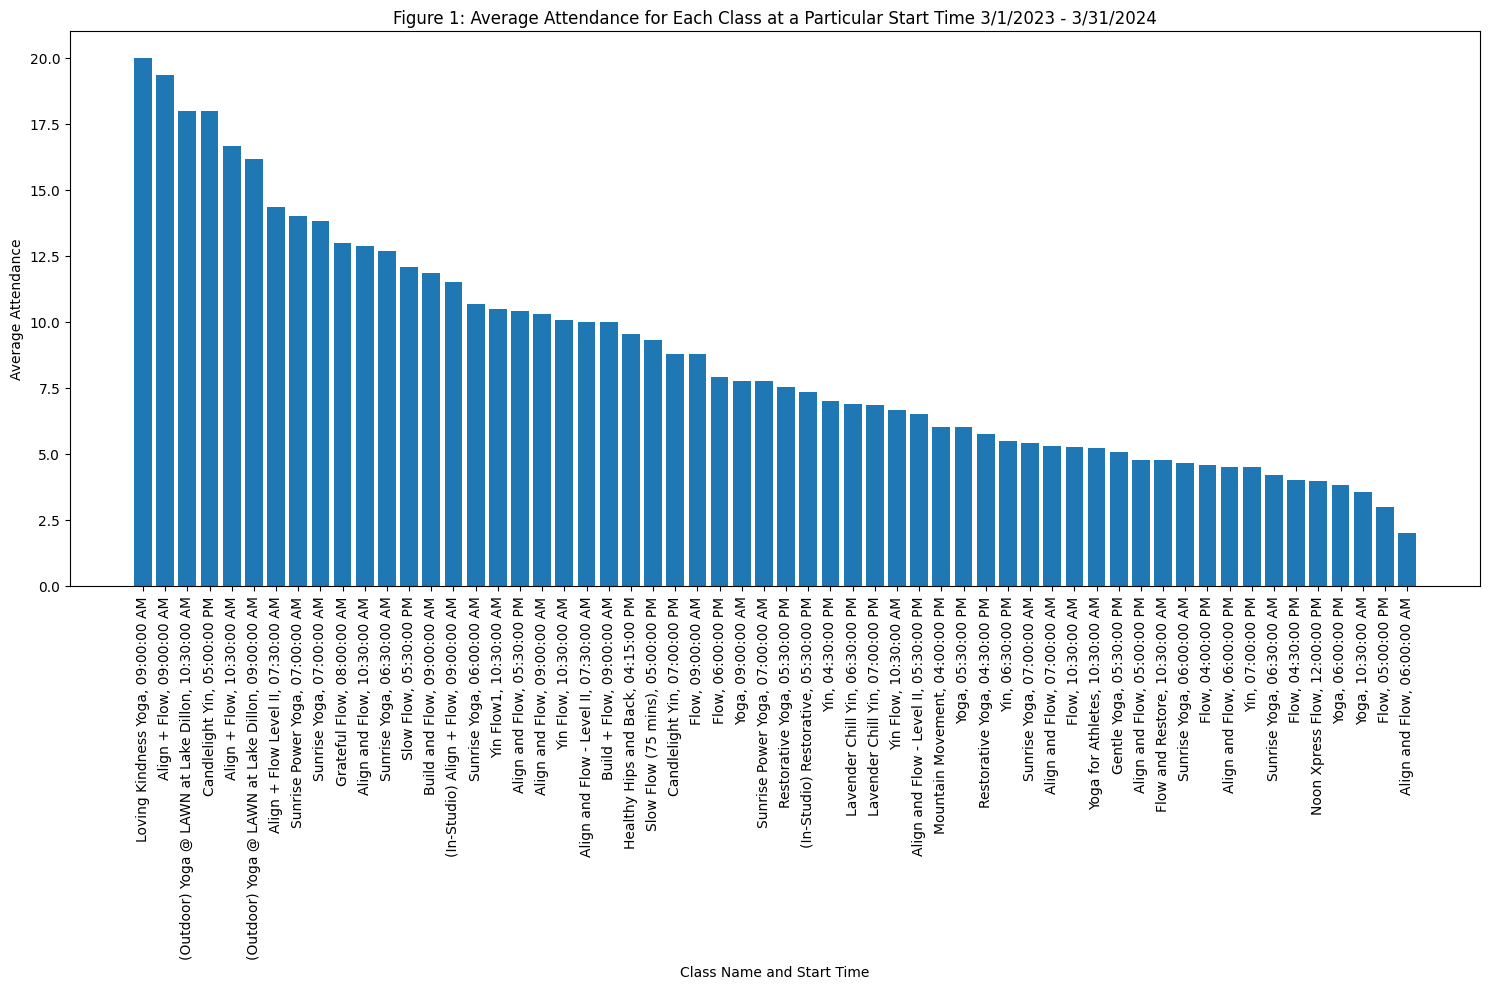

In [4]:
def plot_average_attendance(DF, date_string):
    plt.figure(figsize=(15, 10))
    plt.bar(range(len(DF)), DF['Average Attendance'])
    plt.xlabel('Class Name and Start Time')
    plt.ylabel('Average Attendance')
    plt.title(f'Figure 1: Average Attendance for Each Class at a Particular Start Time {date_string}')
    # creating a loop with a format string to add the class name label based off of each row 
    plt.xticks(range(len(DF)),
            [f"{name.strip()}, {start_time}" for name, start_time in zip(DF['Class Name'], DF['Start Time for Class'])],
            rotation=90)
    plt.tight_layout()
    plt.show()
    
plot_average_attendance(average_attendance, date_string)

Now that we can look into averages in the Data Set, lets dig deeper and look at the difference between class times and those averages 

## Average Attendance Per Class Start Time

In [5]:
def average_by_start_time(DF,  start_date=None, end_date= None):
    
    # using the datetime library imported earlier, you can format the date column in pandas
    DF['Date of Class'] = pd.to_datetime(DF['Date of Class'], format='%m/%d/%Y')
    
    # Based on start_date and end_date parameters, builds a view of the data frame that includes only those dates
    # Then the date_string is formatted to also change the title of the graph
    if start_date is not None and end_date is not None:
        start_date = datetime.strptime(start_date, '%m/%d/%Y')
        end_date = datetime.strptime(end_date, '%m/%d/%Y')
        DF = DF[(DF['Date of Class'] >= start_date) & (DF['Date of Class'] <= end_date)]
        date_string = f'{start_date.strftime("%m/%d/%Y")} thru {end_date.strftime("%m/%d/%Y")}'
    else:
        date_string = '3/1/2023 - 3/31/2024'
    
    # Always good to make copies 
    start_time_df = DF.copy()
    
    # Convert 'Start Time for Class' to datetime objects
    start_time_df['Start Time for Class'] = pd.to_datetime(start_time_df['Start Time for Class'], format='%I:%M:%S %p')
    
    # Group by the Start Time for each class and calculate the mean of each slot rounded to 2 decimals
    start_time_df = start_time_df.groupby('Start Time for Class')['Total Attendance'].mean().reset_index().round(2)
    start_time_df = start_time_df.rename(columns={'Total Attendance': 'Average Attendance'})
    
    # Sort by Start Time
    sorted_start_time = start_time_df.sort_values(by='Start Time for Class')
    
    # Adjust the display of the Start Time for ease of readability
    sorted_start_time['Start Time for Class'] = sorted_start_time['Start Time for Class'].dt.strftime('%H:%M')
    
    attendance_by_start = sorted_start_time.reset_index(drop=True)
    attendance_by_start.index.name = 'Rank'
    
    return attendance_by_start , date_string
    
# Just like above, it is adjustable for dates and will affect the graph below
# If you'd like to average the whole set, leave the dates as None - this data set ranges 
# from 3/1/2023 to 3/31/2024 or from the start and end of your data
# formatted correctly, incorrect dates will not cause an error, but will only average from the data available

attendance_by_start, date_string = average_by_start_time(DF, start_date = None, end_date = None)

attendance_by_start

,Start Time for Class,Average Attendance
Rank,,
0,06:00,4.84
1,06:30,4.91
2,07:00,6.24
3,07:30,10.52
4,08:00,13.00
5,09:00,11.68
6,10:30,8.29
7,12:00,3.97
8,16:00,5.93


## Figure 2: Average Attendance for Class Start Time

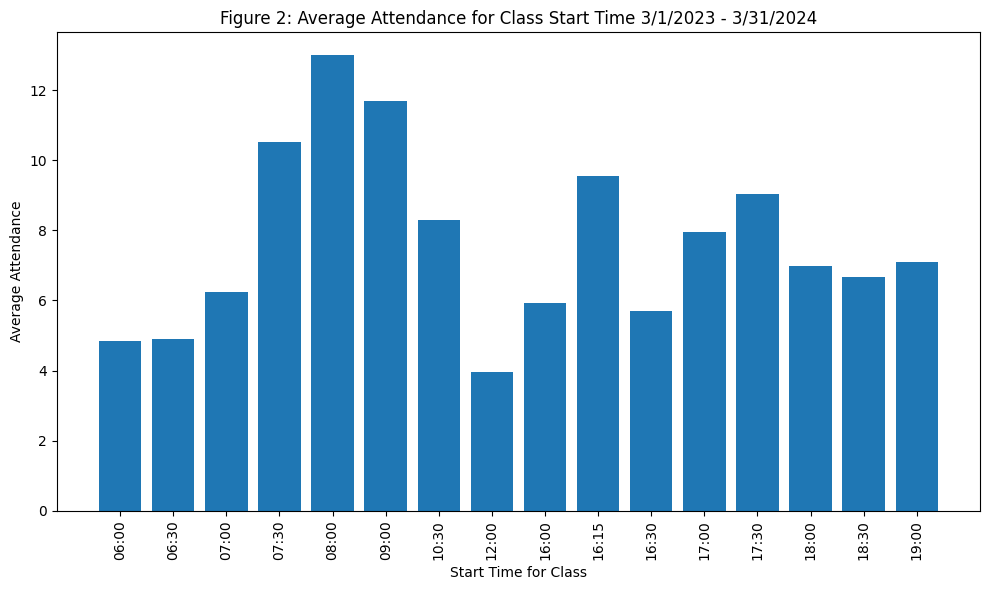

In [6]:
def plot_by_start_time(DF, date_string):
    # For those that like graphs
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(DF)), DF['Average Attendance'])
    plt.xlabel('Start Time for Class')
    plt.ylabel('Average Attendance')
    plt.title(f'Figure 2: Average Attendance for Class Start Time {date_string}')
    # creating a loop with a format string to add the start time label based off of each row 
    plt.xticks(range(len(DF)),
            [f"{day}" for day in DF['Start Time for Class']],
            rotation=90)
    plt.tight_layout()
    plt.show()
    
plot_by_start_time(attendance_by_start , date_string)

Observing the Trend of Class times, the notably popular classes fall around the usual spaces before and after work. The studio community is established, those classes will consistently have a good attendance. 

After talking with the owner, she has great reviews of the 6am and 6:30am yoga classes, as well as the noon classes. She does not want to remove the classes, but instead has decided to push more promotions like free guest passes to members who can get in early and sales on social media. Since this can be an ongoing project, we will observe the numbers in a few more months to compare. 

Next we'll look into trends across different days of the week 

## Breaking down attendance by Day of Week for Figure 3

     Day of Week  Average Attendance
Rank                                
0       Saturday               13.69
1         Sunday               12.14
2         Monday                9.41
3      Wednesday                8.56
4         Friday                8.51
5        Tuesday                7.93
6       Thursday                6.16


/var/folders/61/0_l78kds2tn8v5_4v5frblqc0000gn/T/ipykernel_3822/329006301.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF.loc[:, 'Date'] = pd.to_datetime(DF['Date of Class'], format='%m/%d/%Y')
/var/folders/61/0_l78kds2tn8v5_4v5frblqc0000gn/T/ipykernel_3822/329006301.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF.loc[:, 'Day of Week'] = DF['Date'].apply(lambda x: get_day_of_week(x))


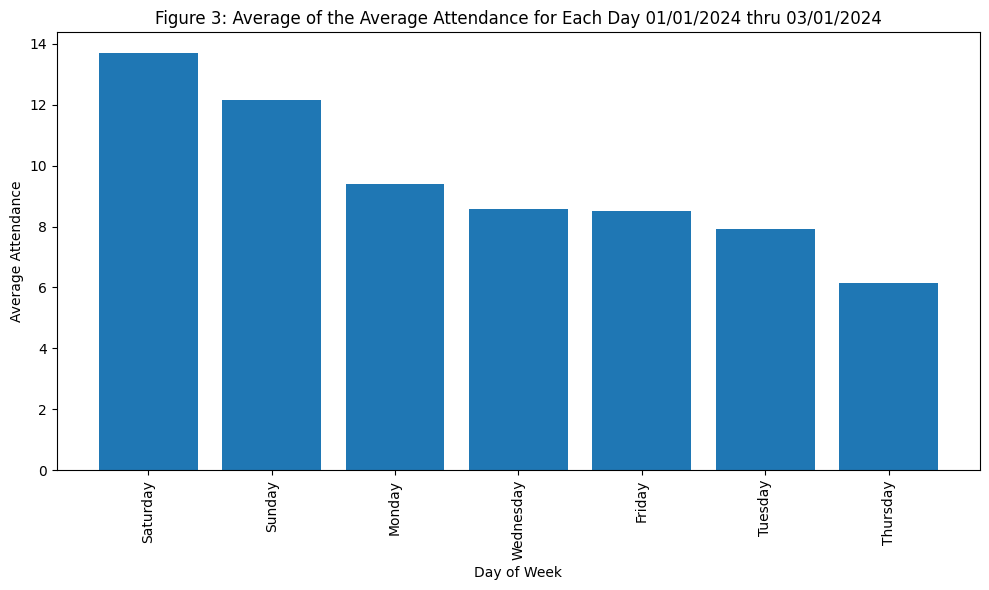

In [7]:
def get_day_of_week(date):
        return date.strftime('%A')  # %A gives the full name of the day (e.g., Monday, Tuesday, etc.)


def plot_by_day(DF, start_date=None, end_date=None):
    # Convert date strings to datetime objects
    DF['Date of Class'] = pd.to_datetime(DF['Date of Class'], format='%m/%d/%Y')
    
    # Filter DataFrame based on date range if provided
    if start_date is not None and end_date is not None:
        start_date = datetime.strptime(start_date, '%m/%d/%Y')
        end_date = datetime.strptime(end_date, '%m/%d/%Y')
        DF = DF[(DF['Date of Class'] >= start_date) & (DF['Date of Class'] <= end_date)]
        date_string = f'{start_date.strftime("%m/%d/%Y")} thru {end_date.strftime("%m/%d/%Y")}'
    else:
        date_string = '3/1/2023 - 3/31/2024'
    
    # Get the day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Use .loc to modify DataFrame without creating a copy
    DF.loc[:, 'Date'] = pd.to_datetime(DF['Date of Class'], format='%m/%d/%Y')
    DF.loc[:, 'Day of Week'] = DF['Date'].apply(lambda x: get_day_of_week(x))

    # Group by 'Day of Week' and calculate the mean attendance
    DoW_attendance_df = DF.groupby(['Day of Week'])['Total Attendance'].mean().reset_index().round(2)
    DoW_attendance_df = DoW_attendance_df.rename(columns={'Total Attendance': 'Average Attendance'})

    sorted_DoW_df = DoW_attendance_df.sort_values(by='Average Attendance', ascending=False).reset_index()
    sorted_DoW_df = sorted_DoW_df.drop(columns=['index'])
    sorted_DoW_df.index.name = 'Rank'

    print(sorted_DoW_df)

    # Graph it
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_DoW_df)), sorted_DoW_df['Average Attendance'])
    plt.xlabel('Day of Week')
    plt.ylabel('Average Attendance')
    plt.title(f'Figure 3: Average of the Average Attendance for Each Day {date_string}')
    plt.xticks(range(len(sorted_DoW_df)),
            [f"{day}" for day in sorted_DoW_df['Day of Week']],
            rotation=90)
    plt.tight_layout()
    plt.show()


plot_by_day(DF, start_date = '01/01/2024', end_date = '03/01/2024')

I was unable to get the warning to go away but it worked how I wanted it to (I tried to change the formatting to the way it directed me to but if you have any feedback I am welcome to it) 

Viewing the breakdown by day is also a valuable insight. A special promo for Thursdays is could give those classes a valuable boost when it comes to attendance! 

## Sorting Classes by Attendance

### Low Attendance

As per the owner's request I also was asked to look into classes with a low average attendance, specifically below 5, as that is the point where the teacher becomes more expensive than the estimated revenue from the students

In [8]:
low_attendance_df = average_attendance[average_attendance['Average Attendance'] < 5]
low_attendance_df.reset_index(drop=True, inplace=True)
low_attendance_df.index.name = 'Rank'
low_attendance_df

,Class Name,Start Time for Class,Average Attendance
Rank,,,
0,Align and Flow,05:00:00 PM,4.78
1,Flow and Restore,10:30:00 AM,4.75
2,Sunrise Yoga,06:00:00 AM,4.65
3,Flow,04:00:00 PM,4.56
4,Align and Flow,06:00:00 PM,4.50
5,Yin,07:00:00 PM,4.50
6,Sunrise Yoga,06:30:00 AM,4.19
7,Flow,04:30:00 PM,4.00
8,Noon Xpress Flow,12:00:00 PM,3.97


To many people, this may look very random but after working and managing a Yoga studio for many years I presume these classes mostly are in the bottom of attendance due to the time in which they start. As the Summit Sol community is very open with which classes they take, there are lots of "Flow"s in the top and the bottom. 

*As a customer of Yoga Studio's myself*, I understand why **5:00pm** weekday classes are difficult to commit to. Align and Flow, and Flow are accessible classes that everyone should attend. It should be prime time, a 30 minute shift could help them greatly. With 5:30pm being one of the most attended time slots in many Yoga Studios (not just Summit Sol). 5:00pm is sometimes lackluster with it being in the heat of traffic and right when people are getting out of work, it doesn't leave much room for error in a routine. Also, since Summit Sol only has one yoga room, if a class could start later and double its average attendance it would be worthwhile to make that shift.

Furthermore, the early morning classes are struggling with attendance, however there is one slot that stands out.  The **7:30** class shows much higher average attendance than the earlier blocks. It also still leaves time for a transition to a **9am** without conflict.

With additional marketing promotions, attendance might improve for the early morning blocks, **6am** is possible with a **7:30** as well, however it has the lowest rate of attendance of any SummitSol time slot. My recommendation would be to continue doing what works. I would shift away from the 6:00am classes, and offer more 7:30 classes. 

*We can then shift over to the opposite end of the spectrum*

## High Attendance

In [9]:
# Creating a data frame of the classes with the highest attendance average

high_attendance_df = average_attendance[average_attendance['Average Attendance'] > 10]
high_attendance_df.reset_index(drop=True, inplace=True)
high_attendance_df.index.name = 'Rank'
high_attendance_df

,Class Name,Start Time for Class,Average Attendance
Rank,,,
0,Loving Kindness Yoga,09:00:00 AM,20.00
1,Align + Flow,09:00:00 AM,19.33
2,(Outdoor) Yoga @ LAWN at Lake Dillon,10:30:00 AM,18.00
3,Candlelight Yin,05:00:00 PM,18.00
4,Align + Flow,10:30:00 AM,16.67
5,(Outdoor) Yoga @ LAWN at Lake Dillon,09:00:00 AM,16.15
6,Align + Flow Level II,07:30:00 AM,14.33
7,Sunrise Power Yoga,07:00:00 AM,14.00
8,Sunrise Yoga,07:00:00 AM,13.83


Its times like these where knowing your data set and your place of work pays off. A caveat to the way I extracted this data, the 5:00pm Candlelight Yin seems to refute my claim that 5:00pm classes are not successful, however since this is a yoga studio I know and love, I know that class is 5:00pm on Sundays without having to look deeper there.

The rest of the highest attended classes mostly coincide with the most popular time slots at other studios. 9:00am, 10:30, and 5:30. Also it is no shocker that the Outdoor Yoga is incredibly popular in a community that is deeply rooted in the outdoors.

It is also important to discuss the classes that fall in the middle. These classes are at risk of underperforming but also have a chance to perform! 

### Middle of the road Attendance

In [10]:
mid_attendance_df = average_attendance[average_attendance['Average Attendance'] < 10]
mid_attendance_df = mid_attendance_df[mid_attendance_df['Average Attendance'] > 5]
mid_attendance_df.reset_index(drop=True, inplace=True)
mid_attendance_df.index.name = 'Rank'
mid_attendance_df

,Class Name,Start Time for Class,Average Attendance
Rank,,,
0,Healthy Hips and Back,04:15:00 PM,9.55
1,Slow Flow (75 mins),05:00:00 PM,9.29
2,Candlelight Yin,07:00:00 PM,8.77
3,Flow,09:00:00 AM,8.76
4,Flow,06:00:00 PM,7.92
5,Yoga,09:00:00 AM,7.77
6,Sunrise Power Yoga,07:00:00 AM,7.77
7,Restorative Yoga,05:30:00 PM,7.52
8,(In-Studio) Restorative,05:30:00 PM,7.33


The 4:15 time slot for Healthy Hips and Back is interesting but I think everyone at the studio agrees it is an incredible class if you can make it. And it only pushes the next class back until 6:00. The 6:00pm is less attended than the 5:30, but sometimes compromises are made for teacher schedules as well. Lots of details to consider. 

**To discuss the seasonality of Summit Sol it is important to get a grasp of monthly attendance as well. **

### Monthly Class Attendance

In [11]:
def get_monthly_attendance(DF):
    # Convert "Date of Class" column to datetime
    DF['Date of Class'] = pd.to_datetime(DF['Date of Class'], format='%m/%d/%Y')
    
    # Extract year and month from the "Date of Class" column
    DF['YearMonth'] = DF['Date of Class'].dt.to_period('M')
    
    # Group by year-month and calculate total attendance per month
    total_attendance_per_month = DF.groupby('YearMonth')['Total Attendance'].sum().reset_index(name='Total Attendance')
    
    # Count all classes that occurred in each month
    classes_per_month = DF.groupby('YearMonth').size().reset_index(name='Total Classes')
    
    # Calculate the average total attendance per class per month
    average_attendance_per_class_per_month = total_attendance_per_month['Total Attendance'] / classes_per_month['Total Classes']

    # Create DataFrame for average total attendance per class per month
    average_attendance_df = pd.DataFrame({
        'YearMonth': total_attendance_per_month['YearMonth'],
        'Total Attendance': total_attendance_per_month['Total Attendance'],
        'Classes Per Month': classes_per_month['Total Classes'],
        'Average Attendance': average_attendance_per_class_per_month
    })
    
    return total_attendance_per_month, average_attendance_df

# Example usage:
# Assuming `DF` is your DataFrame containing attendance data
total_attendance_per_month_df, average_attendance_per_class_df = get_monthly_attendance(DF)

print("Average and Total Attendance per Class per Month:")
print(average_attendance_per_class_df)

Average and Total Attendance per Class per Month:
   YearMonth  Total Attendance  Classes Per Month  Average Attendance
0    2023-03               738                100            7.380000
1    2023-04               591                 91            6.494505
2    2023-05               502                 71            7.070423
3    2023-06               704                 89            7.910112
4    2023-07               839                104            8.067308
5    2023-08               929                117            7.940171
6    2023-09               880                106            8.301887
7    2023-10               532                 68            7.823529
8    2023-11               997                 96           10.385417
9    2023-12              1019                103            9.893204
10   2024-01              1071                116            9.232759
11   2024-02               935                112            8.348214
12   2024-03              1004          

### Figure 4 and 5, Total Monthly Class Attendance and Average Monthly Class Attendance

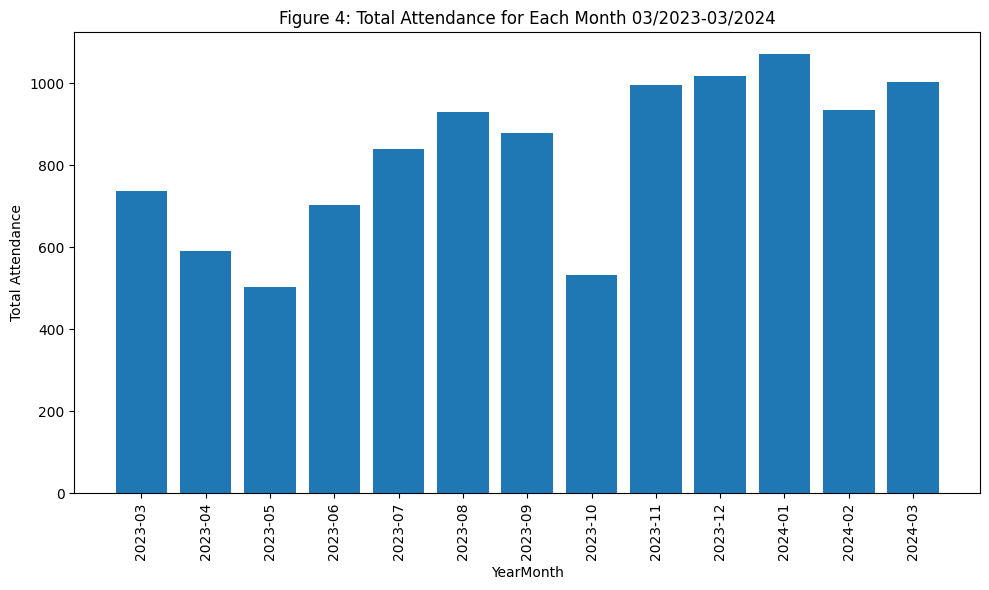

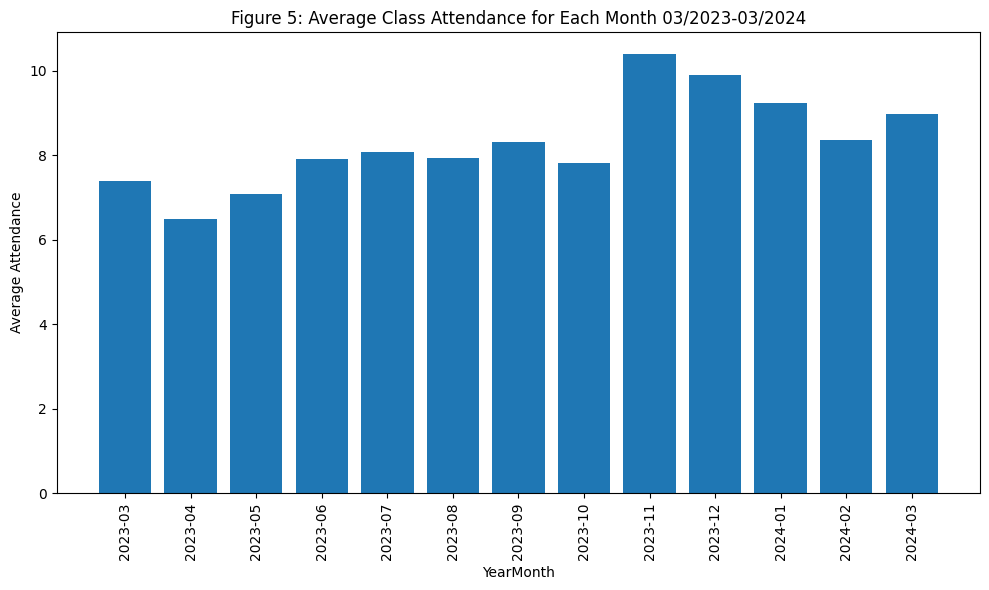

In [12]:
# And here it is visually represented as well

def plot_total_monthly_attendance(DF):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(DF)), DF['Total Attendance'])
    plt.xlabel('YearMonth')
    plt.ylabel('Total Attendance')
    plt.title(f'Figure 4: Total Attendance for Each Month 03/2023-03/2024')
    plt.xticks(range(len(DF)),
            [f"{month}" for month in DF['YearMonth']],
            rotation=90)
    plt.tight_layout()
    plt.show()
    
plot_total_monthly_attendance(total_attendance_per_month_df)

def plot_average_monthly_attendance(DF):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(DF)), DF['Average Attendance'])
    plt.xlabel('YearMonth')
    plt.ylabel('Average Attendance')
    plt.title(f'Figure 5: Average Class Attendance for Each Month 03/2023-03/2024')
    plt.xticks(range(len(DF)),
            [f"{month}" for month in DF['YearMonth']],
            rotation=90)
    plt.tight_layout()
    plt.show()
    
plot_average_monthly_attendance(average_attendance_per_class_df)

Note for improvement: A data point that I do not have access to is the names of registrations to poll which are truly unique but that would be a potential follow up should the export become possible. 

The comparison between these two figures is very interesting. The seasonal lows in monthly trends are very clearly visible, May and October are typically the slowest months in the entire county. 

A great thing to see is that the average class attendance as well as total attendance has been on the rise and thanks to a reduction in classes for the slow months of May and October, class attendance averages remained about the same. 

As May approaches, a mudseason rollback is inevitable, however the summer season comes back strong in July. This is a perfect time to revamp some fun workshops, community events, and outdoor gatherings to keep people coming in. The studio is only showing signs of growth as as they continue to look into data driven insights about scheduling, eventually they will find a model that allows them to bring in the most amount of people possible with the space they have. 

## **Conclusion**

Overall, while observing the data and calculating average attendances it was visually clear there were not many preferences towards class type, however there are four time slots that have a lot of power and pull when it comes to attendance.

**7:30am, 9:00am, 10:30am and 5:30pm** 

These classes consitently show up in the highest listings of average attendance, as well as all working with each other on the schedule. Additional classes can be placed around them, but these should be the root foundation of the schedule on most days. 

Data insights into when attendance is lower, like on Thursdays in general, or to the 6 and 6:30 am classes or 4:00pm classes can also help make decisions in the future. If there is a no other spot for someone on the schedule, an experienced and known teacher might have an easier time pulling students for a non-typical time, whereas the teacher at prime time will usually have the crowd regardless of status. 

This data was very fun to dive deep into especially because it felt very relevant to my own life and helpful to a business and person that I love to work with. I ran into some trouble when initially making the functions with the date range and it seems a bit clunky. Generally I am proud I got them to work and that they don't error out when no data is selected. I would love to get better with my organization of dates or recreate the same analysis but using SQL queries to see how the process can be simplified or enhanced from a different angle. Data is everywhere, even in a safe space of healing and movement, it can usually always be used to benefit the business and those that it serves. 

In the future I hope to export teacher names with the class data so I can look more deeply into those connections soon. Thank you for reading, good luck on the exam!